In [87]:
import os
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

import math

import cv2

### Load data

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [5]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

In [6]:
unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(107, 134)

In [7]:
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [8]:
sample, target, road_image, extra = iter(trainloader).next()
e_id = 0
example = sample[e_id]
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


### BEV class

In [69]:
class BEV:
    
    def __init__(self, image):
    
        self.image = image
        self.angle = [-30, -90, -150, 30, 90, 150]
        self.dst_h,self.dst_w = 400,560
        
    def bev_transform(self, crop_h = 140, dst_h=400, dst_w = 560):
        '''
        dst_h: destination image height
        dst_w: destination image height
        crop_h: crop height for ROI
        '''
        image = self.image
        
        H,W = image.shape[:2]
        
        #source image points
        src = np.float32([[0, H], [W, H], [0, 0], [W, 0]]) 
        #corresponding points in destination image
        dst = np.float32([[270, self.dst_h], [290, dst_h], [0, 0], [dst_w, 0]])
        M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

        image = image[crop_h:H, 0:W] # Apply np slicing for ROI crop

        self.warped = cv2.warpPerspective(image, M, (dst_w, dst_h)) # Image warping: transform to bird eye view
        img = self.warped
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        points = np.array([[[270, dst_h], [290, dst_h], 
                            [59, 0], [511, 0]]]) #make 60 degree angle crop
        # points = np.array([[[lower_left_x,lower_left_y],[lower_right_x,lower_right_y],
        #                   [upper_left_x,upper_left_y],[upper_right_x,upper_right_y]]])

        cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
        self.warped_img = cv2.bitwise_and(img,img,mask = mask)
        
        return self.warped_img
    
    def whole_view(self, dst_h=400, dst_w=560, c_x=465, c_y = 465):
        
        warped_img = self.warped_img

        self.whole_img = np.zeros((c_y*2,c_x*2,3))
        self.whole_img[c_y-dst_h:c_x,c_y-dst_w//2:c_y+dst_w//2] = warped_img
        
        return self.whole_img
    
    def rotateImage(self, angle):
        image = self.whole_img
        dst_image = image.copy()
        (h, w) = image.shape[:2]
        (c_x, c_y) = (w // 2, h // 2)

        transl = np.array((2, 3))

        rotation_matrix = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0 )
        img_rotation = cv2.warpAffine(image, rotation_matrix, (w,h)) 

        return img_rotation


  
    


### Example transforming bev image

In [81]:
image_set = [sample[0][i].numpy().transpose(1, 2, 0) for i in range(len(sample[0]))]

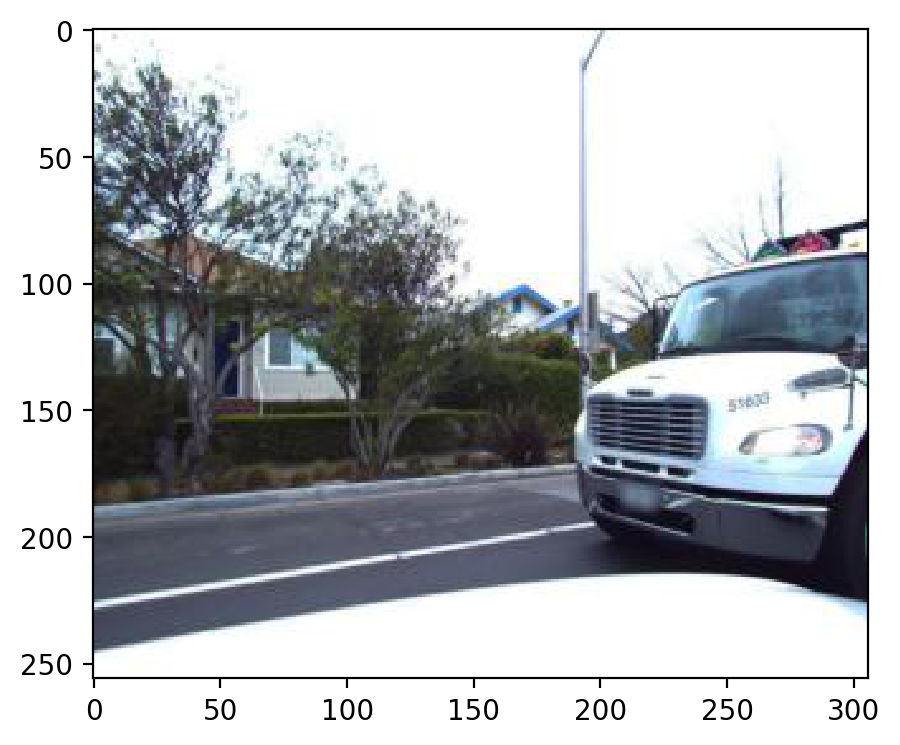

In [11]:
plt.imshow(image_set[0])

2

In [90]:
def bev_overview(image_list):
    for i,img in enumerate(image_list):
        bev = BEV(img)
        warped_img = bev.bev_transform() # transform single image to bev
        whole_img = bev.whole_view() # put bev segment into whole view
        rotated_img = bev.rotateImage(bev.angle[i]) # rotate by corresponding camera angle
        if i == 0:
            bev_img = rotated_img
        else:
            bev_img += rotated_img
    return bev_img

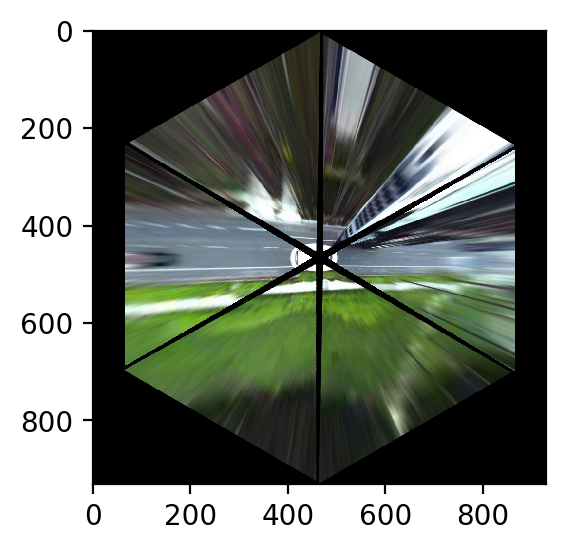

In [91]:
bev_img = bev_overview(image_set)
plt.imshow(bev_img)